# Base Model - using fastText [DONE]

- Train: 75Agree_train
- Test: 75Agree_test

In [1]:
import pandas as pd
import numpy as np
import fasttext
import tempfile
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

def save_fasttext_format(df, filepath):
    with open(filepath, 'w', encoding='utf-8') as f:
        for _, row in df.iterrows():
            f.write(f"__label__{row['label']} {row['sentence']}\n")

### Step 1: Prepate the data to feed the model

In [2]:
# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_41458/3496302679.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)


label
negative    336
neutral     336
positive    336
Name: count, dtype: int64

### Step 2: Hyperparameter tuning

In [3]:
# prepare the k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# hyperparameter tuning area
def get_hyperparameters():
    return {
        "num_train_epochs": int(np.random.randint(20, 100)),
        "learning_rate": float(10 ** np.random.uniform(-5, -2)),
        "dim": np.random.choice([100, 200, 300])
    }

try:
    all_results = pd.read_csv("model fastText.csv")
except FileNotFoundError:
    all_results = pd.DataFrame(columns=["num_train_epochs", "learning_rate", "dim", "eval_loss"])

# start the hyperparameter tuning
for _ in range(0): #range(50)
    current_hyperparameters = get_hyperparameters()
    current_hyperparameters_eval_loss = 0
    current_results = {"num_train_epochs": [], "learning_rate": [], "dim": [] ,"eval_loss": []}

    # make sure the hyperparameters are not already evaluated
    mask = (
        (all_results['num_train_epochs'] == current_hyperparameters['num_train_epochs']) &
        (all_results['learning_rate'] == current_hyperparameters['learning_rate']) &
        (all_results['dim'] == current_hyperparameters['dim'])
    )
    if mask.any():
        print("Hyperparameters already evaluated, skipping...")
        continue
    else:
        print(f"Evaluating hyperparameters: {current_hyperparameters}")
    
    # tuning hyperparameters
    for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["label"])):

        # get the folds
        df_fold_train = df_train.iloc[train_idx]
        df_fold_val = df_train.iloc[val_idx]

        # save the folds in fastText format
        with tempfile.NamedTemporaryFile(delete=False) as f_tr, tempfile.NamedTemporaryFile(delete=False) as f_val:
            save_fasttext_format(df_fold_train, f_tr.name)
            save_fasttext_format(df_fold_val, f_val.name)

            model = fasttext.train_supervised(f_tr.name,
                                              lr=current_hyperparameters["learning_rate"],
                                              epoch=current_hyperparameters["num_train_epochs"],
                                              dim=current_hyperparameters["dim"],
                                              wordNgrams=2, verbose=0)
        
            # get the validation loss
            n, precision, recall = model.test(f_val.name)
            val_loss = 1 - precision

            current_hyperparameters_eval_loss += val_loss
            
            os.unlink(f_tr.name)
            os.unlink(f_val.name)

    # update the results dataframe
    current_results["num_train_epochs"].append(current_hyperparameters["num_train_epochs"])
    current_results["learning_rate"].append(current_hyperparameters["learning_rate"])
    current_results["dim"].append(current_hyperparameters["dim"])
    current_results["eval_loss"].append(current_hyperparameters_eval_loss / skf.n_splits)
    all_results = pd.concat([all_results, pd.DataFrame(current_results)], ignore_index=True)

"Hyperparameter tuning completed. Results saved to model fastText.csv."

'Hyperparameter tuning completed. Results saved to model fastText.csv.'

In [4]:
all_results = all_results.sort_values(by="eval_loss").reset_index(drop=True)
all_results.to_csv("model fastText.csv", index=False)

all_results.head(3)

,num_train_epochs,learning_rate,dim,eval_loss
0,88,0.004601,200,0.470223
1,98,0.000017,300,0.473193
2,52,0.000288,300,0.474213


### Step 3: Extract the best hyperparameters and train the model

In [5]:
best_hyperparameters = all_results.iloc[0]
print(f"Best hyperparameters found in {all_results.shape[0]} tested combinations:")
print(f"Num train epochs: {best_hyperparameters['num_train_epochs']}")
print(f"Dimensionality: {best_hyperparameters['dim']}")
print(f"Learning rate: {best_hyperparameters['learning_rate']}")

Best hyperparameters found in 50 tested combinations:
Num train epochs: 88.0
Dimensionality: 200.0
Learning rate: 0.0046005986384747


In [6]:
# save the folds in fastText format
with tempfile.NamedTemporaryFile(delete=False) as f_train:
    save_fasttext_format(df_train, f_train.name)

    # train the model with the best hyperparameters and the full train set
    model = fasttext.train_supervised(f_train.name,
                                        lr=float(best_hyperparameters["learning_rate"]),
                                        dim=int(best_hyperparameters["dim"]),
                                        epoch=int(best_hyperparameters["num_train_epochs"]),
                                        wordNgrams=2, verbose=0)
    
    os.unlink(f_train.name)


=== Classification Report (Train) ===
              precision    recall  f1-score   support

    negative       0.59      0.64      0.62       336
     neutral       0.51      0.95      0.66       336
    positive       0.93      0.04      0.07       336

    accuracy                           0.54      1008
   macro avg       0.68      0.54      0.45      1008
weighted avg       0.68      0.54      0.45      1008



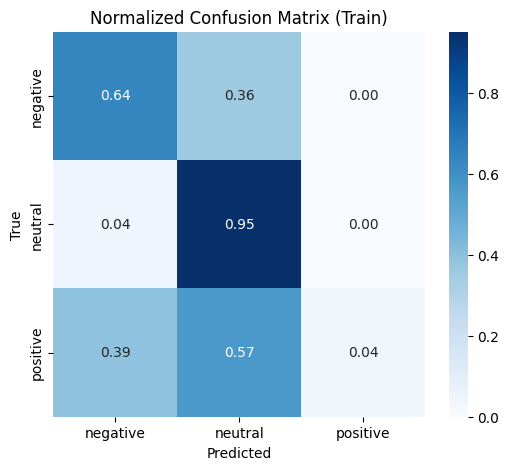


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    negative       0.32      0.64      0.42        84
     neutral       0.76      0.91      0.83       429
    positive       0.50      0.03      0.05       178

    accuracy                           0.65       691
   macro avg       0.53      0.53      0.44       691
weighted avg       0.64      0.65      0.58       691



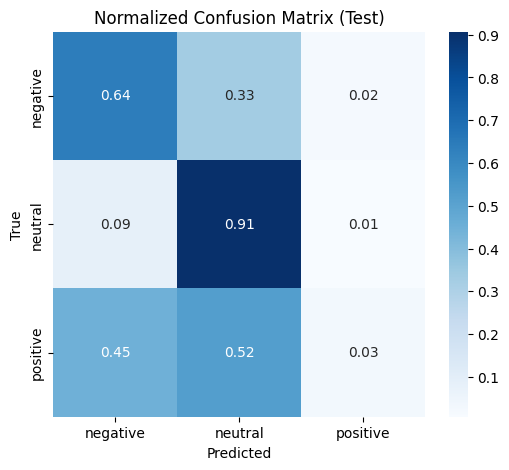

In [7]:
def evaluate_fasttext_model(model, df, split_name):
    y_true, y_pred = [], []

    for row in df.itertuples(index=False):
        label = f"__label__{row.label}"  # assume column name is 'label'
        text = row.sentence                 # assume column name is 'text'
        pred_label, _ = model.predict(text, k=1)
        y_true.append(label.replace("__label__", ""))
        y_pred.append(pred_label[0].replace("__label__", ""))

    labels = sorted(set(y_true))
    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(y_true, y_pred, target_names=labels))

    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Normalized Confusion Matrix ({split_name})")
    plt.show()

evaluate_fasttext_model(model, df_train, "Train")
evaluate_fasttext_model(model, df_test, "Test")